The Infant Health Development Program (IHDP) dataset was collected to investigate the effect of high-quality childcare and home visits on the future cognitive test score of low-birth-weight, premature infants.                                               

#Section 1: Preprocessing data.                                                  
In this section we will be loading CSV file, followed by missing value imputation and removal of outliers

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import seaborn as sns # for visualization
from sklearn.model_selection import RandomizedSearchCV # for hyperparameters tuning
from sklearn.model_selection import cross_val_score # for cross-validation evaluation
from sklearn.metrics import mean_squared_error # to calculate the RMSE
from joblib import dump # to save a model to disk

### Loading dataset

In [5]:
data = pd.read_csv ('ihdp_npci_repl532.csv')
#print(data)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,t,outcome
0,-0.158967,-2.201766,-0.733261,-0.879606,-0.379120,-0.857787,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.976909
1,-1.045229,-1.337276,1.128554,-0.879606,0.683672,0.301522,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.455608
2,-0.785835,-0.602710,0.011465,0.161703,0.371086,-1.189018,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.344970
3,-0.245431,-0.202946,0.011465,1.203011,0.058500,-0.526556,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.024344
4,-1.875288,-1.802002,1.873280,1.203011,0.058500,0.963985,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.126817


In [6]:
data.shape
#data.dtypes

(747, 27)

In [7]:
data.isna().sum()
# data.nunique()

x1         0
x2         0
x3         0
x4         0
x5         0
x6         0
x7         0
x8         0
x9         0
x10        0
x11        0
x12        0
x13        0
x14        0
x15        0
x16        0
x17        0
x18        0
x19        0
x20        0
x21        0
x22        0
x23        0
x24        0
x25        0
t          0
outcome    0
dtype: int64

### Remove outliers

In [8]:
data.info

<bound method DataFrame.info of            x1        x2        x3        x4  ...  x24  x25    t   outcome
0   -0.158967 -2.201766 -0.733261 -0.879606  ...  0.0  0.0  0.0  3.976909
1   -1.045229 -1.337276  1.128554 -0.879606  ...  0.0  0.0  0.0  6.455608
2   -0.785835 -0.602710  0.011465  0.161703  ...  0.0  0.0  0.0  5.344970
3   -0.245431 -0.202946  0.011465  1.203011  ...  0.0  0.0  0.0  7.024344
4   -1.875288 -1.802002  1.873280  1.203011  ...  0.0  0.0  0.0  6.126817
..        ...       ...       ...       ...  ...  ...  ...  ...       ...
742  0.208507  0.196818 -0.360898 -0.879606  ...  0.0  0.0  0.0  2.343596
743  0.208507  0.196818 -1.105624  2.244320  ...  0.0  1.0  0.0  2.985593
744  1.505476  0.996346 -1.105624  2.244320  ...  1.0  0.0  0.0  4.336649
745 -0.310280  0.596582 -0.360898  0.161703  ...  1.0  0.0  0.0  2.314985
746  1.246082  1.396110 -0.360898  2.244320  ...  0.0  0.0  0.0  2.885491

[747 rows x 27 columns]>

In [9]:
data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,t,outcome
count,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,3.061659e-17,2.229364e-17,-5.855795e-17,-6.242218e-16,1.203856e-17,-6.117373e-16,0.514056,0.093708,0.520750,0.364123,0.269076,0.219545,0.358768,1.463186,0.140562,0.959839,0.594378,0.963855,0.135207,0.135207,0.156627,0.081660,0.073628,0.128514,0.157965,0.186078,4.793902
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.500137,0.291618,0.499904,0.481506,0.443777,0.414216,0.479960,0.498977,0.347802,0.196467,0.491341,0.186775,0.342174,0.342174,0.363692,0.274029,0.261339,0.334886,0.364953,0.389430,2.287364
min,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,-1.851480e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.198587
25%,-6.669461e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,-8.577868e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.065484
50%,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,-2.970882e-02,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.347682
75%,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,6.327536e-01,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.497387
max,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,2.951372e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.312816


In [10]:
dt = data[['x1','x2','x3', 'x4', 'x5', 'x6']]
#dt.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8785114ad0>,
      dtype=object)

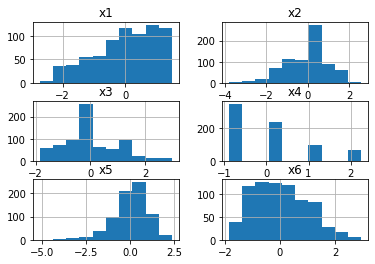

In [11]:
dt.hist()

####We can see extreme values for 'x2' and 'x3' variable. We will plot a box plots for all these variables to locate presence of outliers, if any.

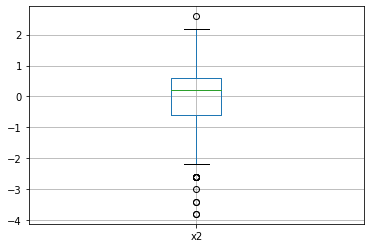

In [12]:
dt.boxplot(column=['x2'])

In [13]:
#dt.boxplot(column=['x3'])

In [14]:
#dt.boxplot(column=['x1'])

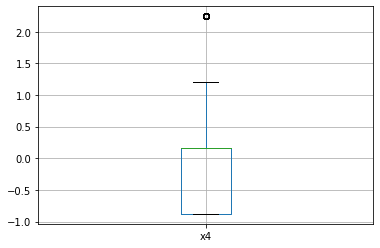

In [15]:
dt.boxplot(column=['x4'])

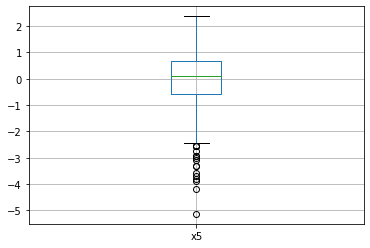

In [16]:
dt.boxplot(column=['x5'])

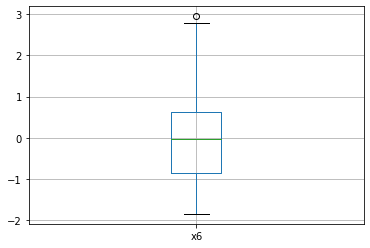

In [17]:
dt.boxplot(column=['x6'])

#### The wiskers in the boxplot for variables x2, x4, x5 & x6, are present outliers.                                                                       The Inner Quertile Range (IQR) is the distance between the upper and lower quartiles.                                                                    We will use the 1.5 * IQR rule to remove outliers.

In [18]:
# Function to compute the lower range and upper range of values to keep (1.5 x IQR)
def range_keep(column):
    sorted(column)
    Q1,Q3 = np.percentile(column , [25,75]) # 25th to 75th percentile (interquartile range)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

In [19]:
# Compute the lower range and upper range for column 'x2'
lower_range, upper_range = range_keep(dt['x2'])
print(lower_range, upper_range)

# Keep only values that lie between that range
data = data.drop(data[(data['x2'] > upper_range) | (data['x2'] < lower_range)].index)

data.shape

-2.401648294142248 2.3955204746270993


(734, 27)

In [20]:
# Compute the lower range and upper range for column 'x5'
lower_range, upper_range = range_keep(data['x5'])
print(lower_range, upper_range)

# Keep only values that lie between that range
data = data.drop(data[(data['x5'] > upper_range) | (data['x5'] < lower_range)].index)

data.shape

-2.2858950564351455 2.4654123243082986


(715, 27)

In [21]:
# Compute the lower range and upper range for column 'x4'
lower_range, upper_range = range_keep(data['x4'])
print(lower_range, upper_range)

# Keep only values that lie between that range
data = data.drop(data[(data['x4'] > upper_range) | (data['x4'] < lower_range)].index)

data.shape

-2.441568761061762 1.7236653000587305


(653, 27)

In [22]:
# Compute the lower range and upper range for column 'x6'
lower_range, upper_range = range_keep(data['x6'])
print(lower_range, upper_range)

# Keep only values that lie between that range
data = data.drop(data[(data['x6'] > upper_range) | (data['x6'] < lower_range)].index)

data.shape

-3.0935973224691447 2.8685640847648997


(652, 27)

In [23]:
df = data[['x1','x2','x3', 'x4', 'x5', 'x6']]
df.head()

,x1,x2,x3,x4,x5,x6
0,-0.158967,-2.201766,-0.733261,-0.879606,-0.379120,-0.857787
1,-1.045229,-1.337276,1.128554,-0.879606,0.683672,0.301522
2,-0.785835,-0.602710,0.011465,0.161703,0.371086,-1.189018
3,-0.245431,-0.202946,0.011465,1.203011,0.058500,-0.526556
4,-1.875288,-1.802002,1.873280,1.203011,0.058500,0.963985


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8784535410>,
      dtype=object)

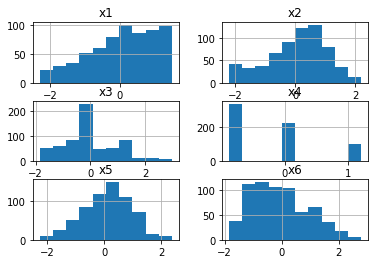

In [24]:
df.hist()

#Section 2: Data Modeling :                                                   
 We are going to try and compare some popular supervise learning models. Since the outcome variable is contiuous, we will pick one of regression methods such as linear regressin, decision tree, random forest or gradient boosting methods.


####Prepare the input and target variables. Extract the target variable 'y'

In [25]:
y = data['outcome']
y.head()

0    3.976909
1    6.455608
2    5.344970
3    7.024344
4    6.126817
Name: outcome, dtype: float64

#### Extract the input variable 'X'

In [26]:
X = data.drop(columns={'outcome'})
X.head()
X.shape

(652, 26)

#### Split training and test tests into 70:30 ratio. 70 % of data will be used for training (and validation), 30 % for test.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

## 2.1 Linear Regression

Scale features (for linear regression)                                        
Feature scaling :

Range from 0 to 1                                                               
'Fit' on training data only                                                     
'Transform' on training and test data

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Scaler for X
scaler_x = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

# Model evaluation by cross-validation
lin_reg_score = cross_val_score(lin_reg, X_train_scaled, y_train, verbose = 2)

# Average Coefficient of determination (R^2) on the validation set
print(f'R^2 Validation: {lin_reg_score.mean()}')

[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
R^2 Validation: 0.7342644286951063


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [30]:
# Fit the model to the training set
lin_reg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
# Compute predictions from the test set
y_pred = lin_reg.predict(X_test_scaled)

In [32]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {lin_reg.score(X_test_scaled, y_test)}')

R^2 Test: 0.7630613492042773


In [33]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 1.1215994621040886


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


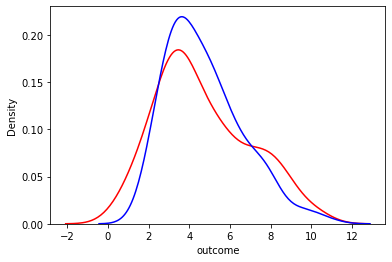

In [34]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("lin_reg.png")

##2.2 Decision Tree


##### For hyperparameter tuning, (to find the optimal hyperparameters) of a model which results in the most 'accurate' predictions. Two available options are GridSearchCV and RandomizedSearchCV. In GridsearchCV we predefine hyperparameters and fit the model to attain better prediction, which can be computaionally expensive. However, RandomizedSearchCV use random combinations of hyperparameters to find best fit solution.  
For this project we are using GridSearchCV.

In [35]:
from sklearn.tree import DecisionTreeRegressor   ### Importing Decision Tree regressor for further analysis
clf =DecisionTreeRegressor()

In [36]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
y_pred = clf.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_test, y_pred)

In [39]:
clf.score(X_test, y_test)

0.5689663505190807

In [40]:
param_dict = {
    'criterion':['mse', 'gini', 'entropy'],
    'max_depth':[1,2,3,4,5,6,None]
}

In [41]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(clf, param_grid= param_dict, cv=10, n_jobs=-1)

In [42]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, None]},
             pre_dispatch

In [43]:
grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [44]:
grid.best_score_

0.6692304061401634

## 2.3 Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [46]:
y_rpred = reg.predict(X_test)

In [47]:
reg.score(X_test, y_test)

0.7737312644817527

In [48]:
# Hyperparameter values to feed to the GridSearchCV
param_grid = {'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': np.arange(5, 41, 5), # Maximum number of levels in tree
               'min_samples_split': [5, 10, 20, 40], # Minimum number of samples required to split a node
               'min_samples_leaf': [2, 6, 12, 24], # Minimum number of samples required at each leaf node
               }

In [49]:
rfor_grid = GridSearchCV(clf, param_grid= param_dict, cv=10, n_jobs=-1)

In [50]:
rfor_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, None]},
             pre_dispatch

In [51]:
rfor_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [52]:
rfor_grid.best_score_

0.6684274528330301

In [53]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {rfor_grid.best_score_}')

R^2 Validation: 0.6684274528330301


In [54]:
# Check the features which are considered as most important in making predictions
sorted(dict(zip(X_train.columns, rfor_grid.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('t', 0.5571335933109883),
 ('x12', 0.16808868141496244),
 ('x9', 0.10244233626062824),
 ('x5', 0.08921728571107791),
 ('x23', 0.04436193583085429),
 ('x1', 0.012304937686929562),
 ('x6', 0.010022467010905983),
 ('x2', 0.00504684205205832),
 ('x3', 0.0038960282086857325),
 ('x7', 0.0030230060510265757),
 ('x4', 0.002342812175308158),
 ('x10', 0.001587968229936549),
 ('x8', 0.0005321060566379777),
 ('x11', 0.0),
 ('x13', 0.0),
 ('x14', 0.0),
 ('x15', 0.0),
 ('x16', 0.0),
 ('x17', 0.0),
 ('x18', 0.0),
 ('x19', 0.0),
 ('x20', 0.0),
 ('x21', 0.0),
 ('x22', 0.0),
 ('x24', 0.0),
 ('x25', 0.0)]

In [55]:
# Compute predictions from the test set
y_pred = rfor_grid.predict(X_test)

In [56]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {rfor_grid.score(X_test, y_test)}')

R^2 Test: 0.692807432267402


In [57]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 1.2771008349529975


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


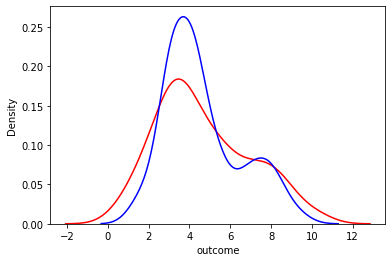

In [58]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("rfor_grid.png")

In [59]:
# Save the model to disk
dump(rfor_grid.best_estimator_, 'rfor_grid.pk1')

['rfor_grid.pk1']

## 2.4 Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
grad_reg = GradientBoostingRegressor()
grad_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
grad_reg.score(X_test, y_test)

0.7831646139094971

In [62]:
# Hyperparameter values to feed to the GridSearchCV
param_dict = {"learning_rate"   : [0.01, 0.1, 0.3],
             "subsample"        : [0.5, 1.0],
             'max_depth'        : np.arange(5, 41, 5),
             "max_features"     : ['auto', 'sqrt'],
             "min_samples_split": [5, 10, 20],
             "min_samples_leaf" : [2, 6, 12]
             }

In [63]:
# Instantiate a GridSearchCV on a GradientBoostingRegressor model with 100 iterations
grad_reg_grid = GridSearchCV(grad_reg, param_grid = param_dict, cv= 10, n_jobs = -1)


In [64]:
grad_reg_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_...
                            

In [65]:
# Check the best parameters found by GridSearchCV
grad_reg_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'subsample': 0.5}

In [66]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {grad_reg_grid.best_score_}')

R^2 Validation: 0.7543249751729505


In [67]:
# Check the features which are considered as most important in making predictions
sorted(dict(zip(X_train.columns, grad_reg_grid.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('t', 0.38639497728016003),
 ('x5', 0.12240258139659652),
 ('x12', 0.09386860906611878),
 ('x9', 0.08460274739168912),
 ('x1', 0.07178111672286787),
 ('x23', 0.045239968900689),
 ('x6', 0.03923243784179774),
 ('x3', 0.03520341600905934),
 ('x2', 0.02925005470501907),
 ('x19', 0.0158382058878662),
 ('x13', 0.011744026091564854),
 ('x15', 0.008619607796332878),
 ('x7', 0.008086847795940417),
 ('x17', 0.00642348565534117),
 ('x4', 0.006163077776412027),
 ('x21', 0.005826543711322104),
 ('x8', 0.004275831938368776),
 ('x24', 0.004092071929364408),
 ('x11', 0.003715890356086333),
 ('x20', 0.0036888902237770297),
 ('x10', 0.003044164748942984),
 ('x14', 0.0026719320659677834),
 ('x22', 0.0026229487322770996),
 ('x25', 0.0022921318481554883),
 ('x18', 0.0019218017307652798),
 ('x16', 0.0009966323975176686)]

In [68]:
# Compute predictions from the test set
y_pred = grad_reg_grid.predict(X_test)

In [69]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {grad_reg_grid.score(X_test, y_test)}')

R^2 Test: 0.7781793417962963


In [70]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 1.085227602992855


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


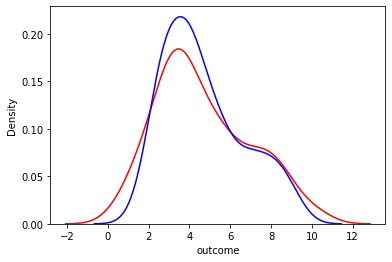

In [71]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("grad_reg.png")

In [72]:
# Save the model to disk
dump(grad_reg_grid.best_estimator_, 'grad_reg.pkl')

['grad_reg.pkl']

### 2.5: XGBoost

In [73]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()

In [74]:
xgb_reg.fit(X_train, y_train)

[15:17:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [75]:
y_pred = xgb_reg.predict(X_test)

In [76]:
xgb_reg.score(X_test, y_test)

0.7902614432306645

In [77]:
# Hyperparameter values to feed to the RandomizedSearchCV
param_grid = {"learning_rate"   : [0.01, 0.1, 0.3] ,
             'max_depth'        : np.arange(5, 41, 5),
             "min_child_weight" : [1, 3, 5, 7],
             "gamma"            : [0.0, 0.1, 0.2, 0.3, 0.4],
             "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
             }

In [78]:
# Instantiate a RandomizedSearchCV on an XGBRegressor model with 100 iterations
xgb_reg_grid = GridSearchCV(xgb_reg, param_grid= param_dict, cv=10, n_jobs = -1)


In [ ]:
xgb_reg_grid.fit(X_train,y_train)

In [ ]:
# Best parameters
xgb_reg_grid.best_estimator_

In [ ]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {xgb_reg_grid.best_score_}')

In [ ]:
# Check the number of times a feature was used to split the data across all trees
sorted(xgb_reg_grid.best_estimator_.get_booster().get_score(importance_type='weight').items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Plot the same data on a graph
from xgboost import plot_importance
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 7))
plot_importance(xgb_reg_grid.best_estimator_, ax=ax)

In [ ]:
# Compute predictions from the test set
y_pred = xgb_reg_grid.predict(X_test)

In [ ]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {xgb_reg_grid.score(X_test, y_test)}')

In [ ]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

In [ ]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("xgb_reg.png")

In [ ]:
# Save the model to disk
dump(xgb_reg.best_estimator_, 'xgb_reg.pkl')